Found eigenvalues: [0.025094706577910762, 0.09939399318851948, 0.10164380308345752, 0.10711154951514149, 0.2199609972803645, 0.22677994825496545, 0.23889261345910956, 0.3823935758671656, 0.3987894885939089, 0.42073773934356434, 0.5827316100395981, 0.6154852323303296, 0.6516008783591963, 0.8205024728529049, 0.875774425518025, 0.9308885068251811, 1.099815180363309, 1.1805531936810758, 1.2583039595449097, 1.4263109034701453, 1.5320147097436243, 1.6337615107284804, 1.8035380573346933, 1.932072269044371, 2.057327582174719, 2.2324839299116848, 2.381706882836575, 2.529162140804377, 2.7128790882376337, 2.8812206980753117, 3.049465209955102, 3.244170208502994, 3.4306105869946273, 3.6184371555563986, 3.825874086185534, 4.029779948566731, 4.2362552872484045, 4.457640456936272, 4.678623705896198, 4.903064119460751]
Attempting to plot the first 13 eigenstates.


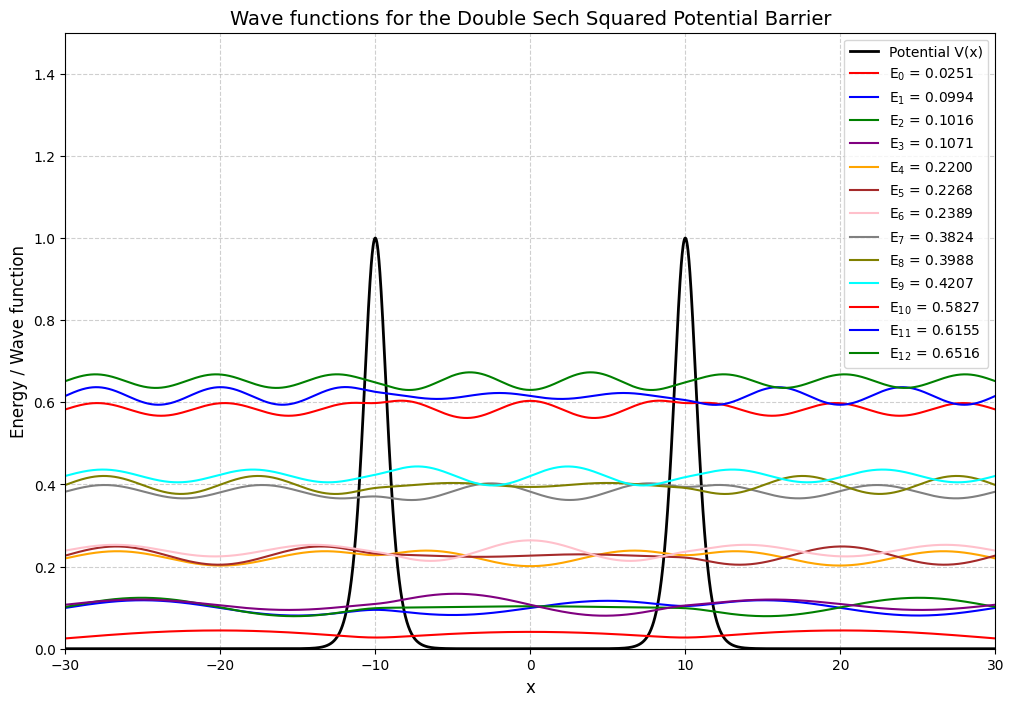

In [1]:
import numpy as np
from scipy.optimize import brentq
from scipy.integrate import simpson
import matplotlib.pyplot as plt

def potential(x, b, a, c):
    """
    Potential function V(x) = b(sech^2((x - a) / c) + sech^2((x + a) / c))
    For positive b, this represents a potential barrier.
    """
    return b / np.cosh((x - a) / c)**2 + b / np.cosh((x + a) / c)**2

def numerov_step(psi_prev, psi_curr, k_prev_sq, k_curr_sq, k_next_sq, dx):
    """
    Applies the Numerov method to find the next point of the wave function.
    Based on the formula:
    psi(x+dx) * (1 + dx^2/12 * k(x+dx)^2) = 2*psi(x) * (1 - 5*dx^2/12 * k(x)^2) - psi(x-dx) * (1 + dx^2/12 * k(x-dx)^2)
    where k(x)^2 = 2m/hbar^2 * (E - V(x)).
    We use units where 2m/hbar^2 = 1 for simplicity, so k^2 = E - V(x).
    """
    # Handle potential barriers where k^2 can be negative. The formula holds directly.
    denom = 1 + dx**2 / 12 * k_next_sq
    if abs(denom) < 1e-10: # Avoid division by near zero
        return np.nan # Return NaN to indicate an issue

    psi_next = (2 * psi_curr * (1 - 5 * dx**2 / 12 * k_curr_sq) -
                psi_prev * (1 + dx**2 / 12 * k_prev_sq)) / denom
    return psi_next


def solve_schrodinger_single_sweep(energy, x, dx, potential_func, params):
    """
    Solves the time-independent Schrödinger equation for a given energy
    using the Numerov method by integrating from the left boundary to the right.
    Assumes hard wall boundary condition psi(x_min) = 0.
    Returns the unnormalized wave function. Uses units where 2m/hbar^2 = 1.
    """
    n_points = len(x)
    psi = np.zeros(n_points)
    psi[0] = 0.0  # Boundary condition at x_min
    psi[1] = 1e-5 * dx  # Small arbitrary non-zero value for psi(x_min + dx)

    k2 = energy - potential_func(x, *params)

    # Apply Numerov method
    for i in range(1, n_points - 1):
        # Ensure indices for k2 are within bounds.
        k_prev_sq = k2[i-1]
        k_curr_sq = k2[i]
        k_next_sq = k2[i+1] if i + 1 < n_points else k2[i] # Approximation for the last step

        psi[i+1] = numerov_step(psi[i-1], psi[i], k_prev_sq, k_curr_sq, k_next_sq, dx)

        if np.isnan(psi[i+1]): # Check for numerical stability issues
             return np.full(n_points, np.nan)


    return psi


def shoot_mismatch(energy, x, dx, potential_func, params):
    """
    Calculates the mismatch for the shooting method with hard wall boundary conditions.
    Integrates from the left boundary and returns the value of the wave function
    at the right boundary. For eigenvalues, this value should be zero.
    Uses units where 2m/hbar^2 = 1.
    """
    psi = solve_schrodinger_single_sweep(energy, x, dx, potential_func, params)
    if np.isnan(psi).any():
        return np.inf # Return large value if integration failed
    return psi[-1] # Value of psi at the right boundary

def normalize_wavefunction(psi, dx):
    """
    Normalizes the wave function using Simpson's rule for integration.
    Returns zero array if normalization is not possible (e.g., all psi are zero or NaN).
    """
    norm_squared = simpson(np.abs(psi)**2, dx=dx)
    if norm_squared > 1e-15: # Avoid division by zero or near zero
        return psi / np.sqrt(norm_squared)
    else:
        return np.zeros_like(psi)


# --- Parameters ---
# Using units where hbar=1 and 2m=1. Energy will be in arbitrary units.
b = 1.0  # Potential parameter (positive for a barrier)
a = 10.0  # Potential parameter
c = 1.0  # Potential parameter

# Spatial grid
x_min = -30.0
x_max = 30.0
n_points = 3001
x, dx = np.linspace(x_min, x_max, n_points, retstep=True)

# Potential on the grid
v_x = potential(x, b, a, c)

# Number of eigenstates to plot
num_eigenstates_to_plot = 13 # You can change this value

# --- Shooting Method to find Eigenvalues ---
# For a positive barrier with hard wall boundary conditions, the energies are positive.
# The energy search range starts from a value slightly above the minimum of the potential
# within the box (which is V(x_min) = V(x_max) = potential at the boundaries, which is close to 0).
# The upper limit of the search needs to be high enough to capture the desired number of eigenvalues.
# A rough estimate for the energy levels in a box of length L is E_n ~ n^2 * pi^2 / (2m * L^2).
# Here L = x_max - x_min = 20. In our units (2m=1), E_n ~ n^2 * pi^2 / L^2.
# For n=5, E_5 ~ 25 * pi^2 / 400 ~ 25 * 9.87 / 400 ~ 0.6

energy_min_search = 0.0  # Energies are positive for a positive potential in a box
energy_max_search = b * 5 # Adjust this based on the potential shape and desired number of states. Or use a higher value.

# Create a range of test energies to find sign changes
# We need enough points to catch the oscillations of the wave function at the boundary
# The number of oscillations increases with energy.
# A higher density of test points might be needed for higher energy states.
num_test_energies = 1000
energies_test = np.linspace(energy_min_search, energy_max_search, num_test_energies)

# Calculate the mismatch (wave function value at the right boundary) for each test energy
mismatch_values = [shoot_mismatch(E, x, dx, potential, (b, a, c)) for E in energies_test]

# Find where the sign of mismatch_values changes to locate approximate eigenvalues
# Filter out intervals where mismatch is NaN
valid_indices = ~np.isnan(mismatch_values)
valid_energies_test = energies_test[valid_indices]
valid_mismatch_values = np.array(mismatch_values)[valid_indices]


sign_changes = np.where(np.sign(valid_mismatch_values[:-1]) != np.sign(valid_mismatch_values[1:]))[0]

eigenvalues = []

# Use brentq to find the accurate eigenvalue in each interval where a sign change occurred
for i in sign_changes:
    try:
        eigenvalue = brentq(shoot_mismatch, valid_energies_test[i], valid_energies_test[i+1],
                            args=(x, dx, potential, (b, a, c)))
        eigenvalues.append(eigenvalue)
    except ValueError:
        # brentq might fail if there are no roots in the interval (e.g., false sign change)
        pass

# Sort the eigenvalues in ascending order
eigenvalues.sort()

print("Found eigenvalues:", eigenvalues)
print(f"Attempting to plot the first {num_eigenstates_to_plot} eigenstates.")

# --- Calculate and Normalize Wave Functions for the first n Eigenvalues ---
wavefunctions = []

# Select the first num_eigenstates_to_plot eigenvalues
eigenvalues_to_plot = eigenvalues[:num_eigenstates_to_plot]

for eigenvalue in eigenvalues_to_plot:
    # Solve the Schrödinger equation for the found eigenvalue using a single sweep
    unnormalized_psi = solve_schrodinger_single_sweep(eigenvalue, x, dx, potential, (b, a, c))

    # Normalize the wave function
    normalized_psi = normalize_wavefunction(unnormalized_psi, dx)
    wavefunctions.append(normalized_psi)

# --- Plotting ---
plt.figure(figsize=(12, 8))
plt.plot(x, v_x, label="Potential V(x)", color='black', linewidth=2)
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']

for i, E in enumerate(eigenvalues_to_plot):
    if i < len(wavefunctions) and not np.isnan(wavefunctions[i]).any():
        # Plot wave function shifted by the energy for better visualization
        plt.plot(x, wavefunctions[i] * (max(v_x) - min(v_x)) * 0.1 + E, label=f"E$_{{{i}}}$ = {E:.4f}", color=colors[i % len(colors)]) # Scale psi for plotting

plt.xlabel("x", fontsize=12)
plt.ylabel("Energy / Wave function", fontsize=12)
plt.title("Wave functions for the Double Sech Squared Potential Barrier", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(min(v_x) * 1.1, max(v_x) * 1.5) # Adjust y-limits for better visualization
plt.xlim(x_min, x_max)
plt.show()

In [1]:
import numpy as np
from scipy.optimize import brentq
from scipy.integrate import simpson
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- Physics Functions (Same as before) ---

def potential(x, b, a, c):
    """
    Potential function V(x) = b(sech^2((x - a) / c) + sech^2((x + a) / c))
    For positive b, this represents a potential barrier.
    """
    return b / np.cosh((x - a) / c)**2 + b / np.cosh((x + a) / c)**2

def numerov_step(psi_prev, psi_curr, k_prev_sq, k_curr_sq, k_next_sq, dx):
    """
    Applies the Numerov method to find the next point of the wave function.
    Based on the formula:
    psi(x+dx) * (1 + dx^2/12 * k(x+dx)^2) = 2*psi(x) * (1 - 5*dx^2/12 * k(x)^2) - psi(x-dx) * (1 + dx^2/12 * k(x-dx)^2)
    where k(x)^2 = 2m/hbar^2 * (E - V(x)).
    We use units where 2m/hbar^2 = 1 for simplicity, so k^2 = E - V(x).
    """
    # Handle potential barriers where k^2 can be negative. The formula holds directly.
    denom = 1 + dx**2 / 12 * k_next_sq
    if abs(denom) < 1e-10: # Avoid division by near zero
        return np.nan # Return NaN to indicate an issue

    psi_next = (2 * psi_curr * (1 - 5 * dx**2 / 12 * k_curr_sq) -
                psi_prev * (1 + dx**2 / 12 * k_prev_sq)) / denom
    return psi_next


def solve_schrodinger_single_sweep(energy, x, dx, potential_func, params):
    """
    Solves the time-independent Schrödinger equation for a given energy
    using the Numerov method by integrating from the left boundary to the right.
    Assumes hard wall boundary condition psi(x_min) = 0.
    Returns the unnormalized wave function. Uses units where 2m/hbar^2 = 1.
    """
    n_points = len(x)
    psi = np.zeros(n_points)
    psi[0] = 0.0  # Boundary condition at x_min
    # Small arbitrary non-zero value for psi(x_min + dx).
    # The exact value doesn't matter as the function is normalized later.
    psi[1] = 1e-6 * dx

    k2 = energy - potential_func(x, *params)

    # Apply Numerov method
    # We integrate up to n_points - 2 to calculate psi[n_points - 1]
    for i in range(1, n_points - 1):
        # Ensure indices for k2 are within bounds.
        k_prev_sq = k2[i-1]
        k_curr_sq = k2[i]
        # Use k2[i] for the last step k2[i+1] if i+1 is out of bounds.
        # This is an approximation but acceptable given the step nature.
        k_next_sq = k2[i+1] if i + 1 < n_points else k2[i]

        psi[i+1] = numerov_step(psi[i-1], psi[i], k_prev_sq, k_curr_sq, k_next_sq, dx)

        if np.isnan(psi[i+1]): # Check for numerical stability issues
             # Propagate NaN if a step failed
             psi[i+1:] = np.nan
             break

    return psi


def shoot_mismatch(energy, x, dx, potential_func, params):
    """
    Calculates the mismatch for the shooting method with hard wall boundary conditions.
    Integrates from the left boundary and returns the value of the wave function
    at the right boundary. For eigenvalues, this value should be zero.
    Uses units where 2m/hbar^2 = 1.
    """
    psi = solve_schrodinger_single_sweep(energy, x, dx, potential_func, params)
    if np.isnan(psi).any():
        return np.inf # Return large value if integration failed
    return psi[-1] # Value of psi at the right boundary

def normalize_wavefunction(psi, x):
    """
    Normalizes the wave function using Simpson's rule for integration.
    Returns zero array if normalization is not possible (e.g., all psi are zero or NaN).
    Uses the x array to get dx implicitly for Simpson's rule if needed,
    or explicitly calculates dx. Using x directly is more robust with simpson.
    """
    # Check if psi contains NaNs or is all zeros
    if np.isnan(psi).any() or np.all(psi == 0):
        return np.zeros_like(psi)

    # Simpson's rule requires at least 3 points
    if len(x) < 3:
        return np.zeros_like(psi)

    norm_squared = simpson(np.abs(psi)**2, x=x) # Use x for simpson for robust dx handling

    if norm_squared > 1e-15: # Avoid division by zero or near zero
        return psi / np.sqrt(norm_squared)
    else:
        return np.zeros_like(psi)

# --- Spatial Grid (Fixed for this example) ---
x_min = -30.0
x_max = 30.0
n_points = 3001
x, dx = np.linspace(x_min, x_max, n_points, retstep=True)

# --- Interactive Plotting Function ---

def plot_eigenstate(b, a, c, eigenstate_index):
    """
    Calculates eigenvalues and wave functions for the given potential parameters
    and plots the selected eigenstate.
    """
    # Ensure we are plotting in the output widget
    with output:
        clear_output(wait=True) # Clear previous plot

        # --- Potential on the grid ---
        v_x = potential(x, b, a, c)

        # --- Shooting Method to find Eigenvalues ---
        # Adjust energy search range based on potential parameters.
        # Simple heuristic: energy levels are roughly bounded by potential features
        # and the box size. Add some dependency on b and a.
        energy_min_search = 0.0
        # Make upper bound somewhat dependent on barrier height and position separation
        energy_max_search = max(5.0, b * 3 + abs(a) * 0.1)

        # Increase number of test energies for higher energy states or narrower barriers
        num_test_energies = 1500 # Increased from 1000
        energies_test = np.linspace(energy_min_search, energy_max_search, num_test_energies)

        # Calculate the mismatch (wave function value at the right boundary)
        mismatch_values = [shoot_mismatch(E, x, dx, potential, (b, a, c)) for E in energies_test]

        # Find where the sign of mismatch_values changes to locate approximate eigenvalues
        # Filter out intervals where mismatch is NaN
        valid_indices = ~np.isnan(mismatch_values)
        valid_energies_test = energies_test[valid_indices]
        valid_mismatch_values = np.array(mismatch_values)[valid_indices]

        # Need at least two valid points to check for sign changes
        sign_changes = []
        if len(valid_mismatch_values) > 1:
             sign_changes = np.where(np.sign(valid_mismatch_values[:-1]) != np.sign(valid_mismatch_values[1:]))[0]

        eigenvalues = []

        # Use brentq to find the accurate eigenvalue in each interval where a sign change occurred
        for i in sign_changes:
            try:
                # Ensure interval endpoints for brentq are distinct and valid
                e_low = valid_energies_test[i]
                e_high = valid_energies_test[i+1]
                if e_high > e_low:
                    eigenvalue = brentq(shoot_mismatch, e_low, e_high,
                                        args=(x, dx, potential, (b, a, c)))
                    eigenvalues.append(eigenvalue)
            except ValueError:
                # brentq might fail if there are no roots in the interval (e.g., false sign change due to numerical noise)
                pass
            except RuntimeWarning:
                 # Catch potential runtime warnings from brentq
                 pass


        # Sort the eigenvalues in ascending order
        eigenvalues.sort()

        n_eigenvalues = len(eigenvalues)

        print(f"Found {n_eigenvalues} eigenvalues.")
        if n_eigenvalues > 0:
            print("Eigenvalues (approx):", [f"{E:.4f}" for E in eigenvalues])
        else:
            print("No eigenvalues found in the search range.")

        # --- Select and Plot the Requested Eigenstate ---

        plt.figure(figsize=(12, 8))
        ax = plt.gca() # Get current axes

        # Plot the potential
        ax.plot(x, v_x, label=f"Potential V(x) [b={b}, a={a}, c={c}]", color='black', linewidth=2)

        plotted_eigenvalue = None # To store the energy of the plotted state

        if n_eigenvalues > 0:
            # Ensure the requested index is within the valid range
            actual_eigenstate_index = min(max(0, eigenstate_index), n_eigenvalues - 1)

            # Get the eigenvalue for the selected index
            plotted_eigenvalue = eigenvalues[actual_eigenstate_index]

            # Solve for the wave function at this eigenvalue
            unnormalized_psi = solve_schrodinger_single_sweep(plotted_eigenvalue, x, dx, potential, (b, a, c))

            # Normalize the wave function
            normalized_psi = normalize_wavefunction(unnormalized_psi, x)

            # Check if normalization was successful
            if not np.all(normalized_psi == 0):
                # Plot the wave function shifted by the energy for better visualization
                # Scale psi for plotting relative to potential height difference
                psi_scaling = (np.max(v_x) - np.min(v_x)) * 0.1 if np.max(v_x) != np.min(v_x) else 1.0
                ax.plot(x, normalized_psi * psi_scaling + plotted_eigenvalue,
                        label=f"State {actual_eigenstate_index}: E = {plotted_eigenvalue:.4f}", color='red')

                ax.text(x_min * 0.95, plotted_eigenvalue, f'E$_{{{actual_eigenstate_index}}}$', va='center', ha='right', color='red')
            else:
                 ax.text((x_min + x_max) / 2, np.max(v_x) * 0.8, "Failed to calculate/normalize wave function for this state.", ha='center', va='center', color='red')
                 plotted_eigenvalue = None # Indicate no state was plotted

            # Update the max value of the eigenstate_index slider
        else:
             ax.text((x_min + x_max) / 2, np.max(v_x) * 0.8, "No eigenvalues found to plot.", ha='center', va='center', color='red')


        ax.set_xlabel("x", fontsize=12)
        ax.set_ylabel("Energy / Wave function", fontsize=12)
        ax.set_title("Selected Eigenstate for Double Sech Squared Potential Barrier", fontsize=14)
        ax.legend(fontsize=10)
        ax.grid(True, linestyle='--', alpha=0.6)
        # Adjust y-limits for better visualization, ensuring potential is visible
        y_min_plot = min(np.min(v_x), plotted_eigenvalue - abs(psi_scaling) if plotted_eigenvalue is not None else np.min(v_x)) * 1.1
        y_max_plot = max(np.max(v_x), plotted_eigenvalue + abs(psi_scaling) if plotted_eigenvalue is not None else np.max(v_x)) * 1.2
        ax.set_ylim(y_min_plot, y_max_plot)
        ax.set_xlim(x_min, x_max)
        plt.show()


# --- Create ipywidgets ---

# Sliders for potential parameters
b_slider = widgets.FloatSlider(min=0.1, max=5.0, step=0.1, value=1.0, description='b:', continuous_update=False, orientation='horizontal', readout_format='.1f')
a_slider = widgets.FloatSlider(min=1.0, max=20.0, step=0.5, value=10.0, description='a:', continuous_update=False, orientation='horizontal', readout_format='.1f')
c_slider = widgets.FloatSlider(min=0.5, max=5.0, step=0.1, value=1.0, description='c:', continuous_update=False, orientation='horizontal', readout_format='.1f')

# Slider to select the eigenstate index
# The maximum value here is just an initial guess. The number of states depends on the potential.
# We handle out-of-range indices within the plotting function.
eigenstate_index_slider = widgets.IntSlider(min=0, max=20, step=1, value=0, description='State Index:', continuous_update=False, orientation='horizontal', readout=True)

# Output widget to display the plot
output = widgets.Output()

# --- Link widgets to the plotting function ---

# Use interactive_output to separate controls from the output area
interactive_plot = widgets.interactive_output(
    plot_eigenstate,
    {'b': b_slider, 'a': a_slider, 'c': c_slider, 'eigenstate_index': eigenstate_index_slider}
)

# --- Arrange and Display Widgets and Output ---

# Create containers for the widgets
controls_vbox = widgets.VBox([
    widgets.Label("Adjust Potential Parameters:"),
    b_slider,
    a_slider,
    c_slider,
    widgets.Label("Select Eigenstate to Plot:"),
    eigenstate_index_slider
])

# Display the controls and the output plot
display(controls_vbox, output)

# Initial plot call (optional, interactive_output will call it on first display)
# plot_eigenstate(b_slider.value, a_slider.value, c_slider.value, eigenstate_index_slider.value)

Output()

Found eigenvalues: [0.025094706577910762, 0.09939399318851948, 0.10164380308345752, 0.10711154951514149, 0.2199609972803645, 0.22677994825496545, 0.23889261345910956, 0.3823935758671656, 0.3987894885939089, 0.42073773934356434, 0.5827316100395981, 0.6154852323303296, 0.6516008783591963, 0.8205024728529049, 0.875774425518025, 0.9308885068251811, 1.099815180363309, 1.1805531936810758, 1.2583039595449097, 1.4263109034701453, 1.5320147097436243, 1.6337615107284804, 1.8035380573346933, 1.932072269044371, 2.057327582174719, 2.2324839299116848, 2.381706882836575, 2.529162140804377, 2.7128790882376337, 2.8812206980753117, 3.049465209955102, 3.244170208502994, 3.4306105869946273, 3.6184371555563986, 3.825874086185534, 4.029779948566731, 4.2362552872484045, 4.457640456936272, 4.678623705896198, 4.903064119460751]
Attempting to plot the first 20 eigenstates.


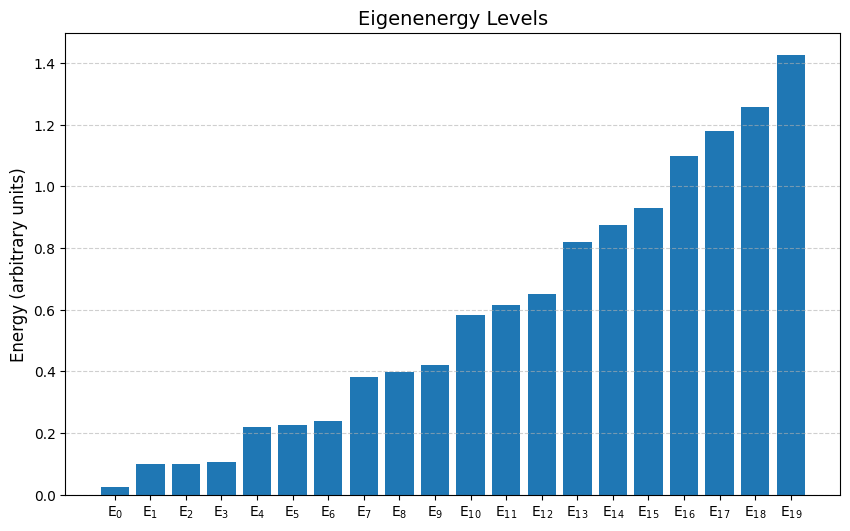

In [2]:
import numpy as np
from scipy.optimize import brentq
from scipy.integrate import simpson
import matplotlib.pyplot as plt

def potential(x, b, a, c):
    """
    Potential function V(x) = b(sech^2((x - a) / c) + sech^2((x + a) / c))
    For positive b, this represents a potential barrier.
    """
    return b / np.cosh((x - a) / c)**2 + b / np.cosh((x + a) / c)**2

def numerov_step(psi_prev, psi_curr, k_prev_sq, k_curr_sq, k_next_sq, dx):
    """
    Applies the Numerov method to find the next point of the wave function.
    Based on the formula:
    psi(x+dx) * (1 + dx^2/12 * k(x+dx)^2) = 2*psi(x) * (1 - 5*dx^2/12 * k(x)^2) - psi(x-dx) * (1 + dx^2/12 * k(x-dx)^2)
    where k(x)^2 = 2m/hbar^2 * (E - V(x)).
    We use units where 2m/hbar^2 = 1 for simplicity, so k^2 = E - V(x).
    """
    # Handle potential barriers where k^2 can be negative. The formula holds directly.
    denom = 1 + dx**2 / 12 * k_next_sq
    if abs(denom) < 1e-10: # Avoid division by near zero
        return np.nan # Return NaN to indicate an issue

    psi_next = (2 * psi_curr * (1 - 5 * dx**2 / 12 * k_curr_sq) -
                  psi_prev * (1 + dx**2 / 12 * k_prev_sq)) / denom
    return psi_next


def solve_schrodinger_single_sweep(energy, x, dx, potential_func, params):
    """
    Solves the time-independent Schrödinger equation for a given energy
    using the Numerov method by integrating from the left boundary to the right.
    Assumes hard wall boundary condition psi(x_min) = 0.
    Returns the unnormalized wave function. Uses units where 2m/hbar^2 = 1.
    """
    n_points = len(x)
    psi = np.zeros(n_points)
    psi[0] = 0.0  # Boundary condition at x_min
    psi[1] = 1e-5 * dx  # Small arbitrary non-zero value for psi(x_min + dx)

    k2 = energy - potential_func(x, *params)

    # Apply Numerov method
    for i in range(1, n_points - 1):
        # Ensure indices for k2 are within bounds.
        k_prev_sq = k2[i-1]
        k_curr_sq = k2[i]
        k_next_sq = k2[i+1] if i + 1 < n_points else k2[i] # Approximation for the last step

        psi[i+1] = numerov_step(psi[i-1], psi[i], k_prev_sq, k_curr_sq, k_next_sq, dx)

        if np.isnan(psi[i+1]): # Check for numerical stability issues
             return np.full(n_points, np.nan)


    return psi


def shoot_mismatch(energy, x, dx, potential_func, params):
    """
    Calculates the mismatch for the shooting method with hard wall boundary conditions.
    Integrates from the left boundary and returns the value of the wave function
    at the right boundary. For eigenvalues, this value should be zero.
    Uses units where 2m/hbar^2 = 1.
    """
    psi = solve_schrodinger_single_sweep(energy, x, dx, potential_func, params)
    if np.isnan(psi).any():
        return np.inf # Return large value if integration failed
    return psi[-1] # Value of psi at the right boundary

def normalize_wavefunction(psi, dx):
    """
    Normalizes the wave function using Simpson's rule for integration.
    Returns zero array if normalization is not possible (e.g., all psi are zero or NaN).
    """
    norm_squared = simpson(np.abs(psi)**2, dx=dx)
    if norm_squared > 1e-15: # Avoid division by zero or near zero
        return psi / np.sqrt(norm_squared)
    else:
        return np.zeros_like(psi)


# --- Parameters ---
# Using units where hbar=1 and 2m=1. Energy will be in arbitrary units.
b = 1.0  # Potential parameter (positive for a barrier)
a = 10.0  # Potential parameter
c = 1.0  # Potential parameter

# Spatial grid
x_min = -30.0
x_max = 30.0
n_points = 3001
x, dx = np.linspace(x_min, x_max, n_points, retstep=True)

# Potential on the grid
v_x = potential(x, b, a, c)

# Number of eigenstates to plot
num_eigenstates_to_plot = 20 # You can change this value

# --- Shooting Method to find Eigenvalues ---
# For a positive barrier with hard wall boundary conditions, the energies are positive.
# The energy search range starts from a value slightly above the minimum of the potential
# within the box (which is V(x_min) = V(x_max) = potential at the boundaries, which is close to 0).
# The upper limit of the search needs to be high enough to capture the desired number of eigenvalues.
# A rough estimate for the energy levels in a box of length L is E_n ~ n^2 * pi^2 / (2m * L^2).
# Here L = x_max - x_min = 20. In our units (2m=1), E_n ~ n^2 * pi^2 / L^2.
# For n=5, E_5 ~ 25 * pi^2 / 400 ~ 0.6

energy_min_search = 0.0  # Energies are positive for a positive potential in a box
energy_max_search = b * 5 # Adjust this based on the potential shape and desired number of states. Or use a higher value.

# Create a range of test energies to find sign changes
# We need enough points to catch the oscillations of the wave function at the boundary
# The number of oscillations increases with energy.
# A higher density of test points might be needed for higher energy states.
num_test_energies = 1000
energies_test = np.linspace(energy_min_search, energy_max_search, num_test_energies)

# Calculate the mismatch (wave function value at the right boundary) for each test energy
mismatch_values = [shoot_mismatch(E, x, dx, potential, (b, a, c)) for E in energies_test]

# Find where the sign of mismatch_values changes to locate approximate eigenvalues
# Filter out intervals where mismatch is NaN
valid_indices = ~np.isnan(mismatch_values)
valid_energies_test = energies_test[valid_indices]
valid_mismatch_values = np.array(mismatch_values)[valid_indices]


sign_changes = np.where(np.sign(valid_mismatch_values[:-1]) != np.sign(valid_mismatch_values[1:]))[0]

eigenvalues = []

# Use brentq to find the accurate eigenvalue in each interval where a sign change occurred
for i in sign_changes:
    try:
        eigenvalue = brentq(shoot_mismatch, valid_energies_test[i], valid_energies_test[i+1],
                                         args=(x, dx, potential, (b, a, c)))
        eigenvalues.append(eigenvalue)
    except ValueError:
        # brentq might fail if there are no roots in the interval (e.g., false sign change)
        pass

# Sort the eigenvalues in ascending order
eigenvalues.sort()

print("Found eigenvalues:", eigenvalues)
print(f"Attempting to plot the first {num_eigenstates_to_plot} eigenstates.")

# --- Calculate and Normalize Wave Functions for the first n Eigenvalues ---
wavefunctions = []

# Select the first num_eigenstates_to_plot eigenvalues
eigenvalues_to_plot = eigenvalues[:num_eigenstates_to_plot]

for eigenvalue in eigenvalues_to_plot:
    # Solve the Schrödinger equation for the found eigenvalue using a single sweep
    unnormalized_psi = solve_schrodinger_single_sweep(eigenvalue, x, dx, potential, (b, a, c))

    # Normalize the wave function
    normalized_psi = normalize_wavefunction(unnormalized_psi, dx)
    wavefunctions.append(normalized_psi)

# --- Plotting Eigenvalues ---
plt.figure(figsize=(10, 6))
plt.bar(range(len(eigenvalues_to_plot)), eigenvalues_to_plot)
plt.xticks(range(len(eigenvalues_to_plot)), [f'E$_{{{i}}}$' for i in range(len(eigenvalues_to_plot))])
plt.ylabel("Energy (arbitrary units)", fontsize=12)
plt.title("Eigenenergy Levels", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

Calculating eigenvalues for a = 0.0
Found 34 eigenvalues for a = 0.0
Calculating eigenvalues for a = 1.0
Found 32 eigenvalues for a = 1.0
Calculating eigenvalues for a = 5.0
Found 36 eigenvalues for a = 5.0
Calculating eigenvalues for a = 10.0
Found 40 eigenvalues for a = 10.0
Calculating eigenvalues for a = 15.0
Found 40 eigenvalues for a = 15.0


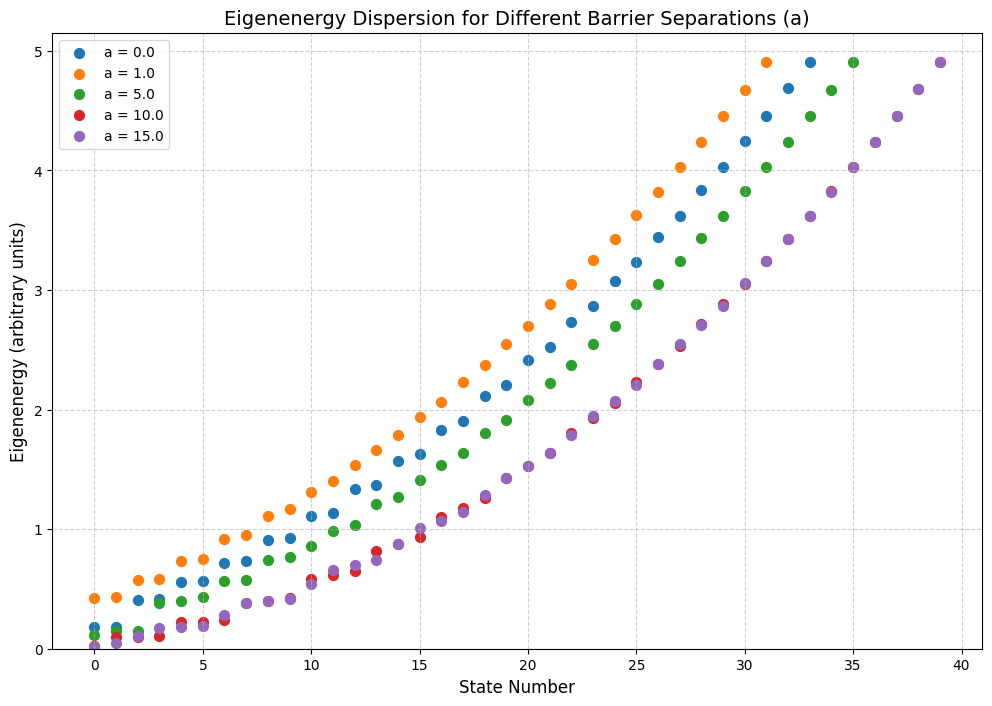

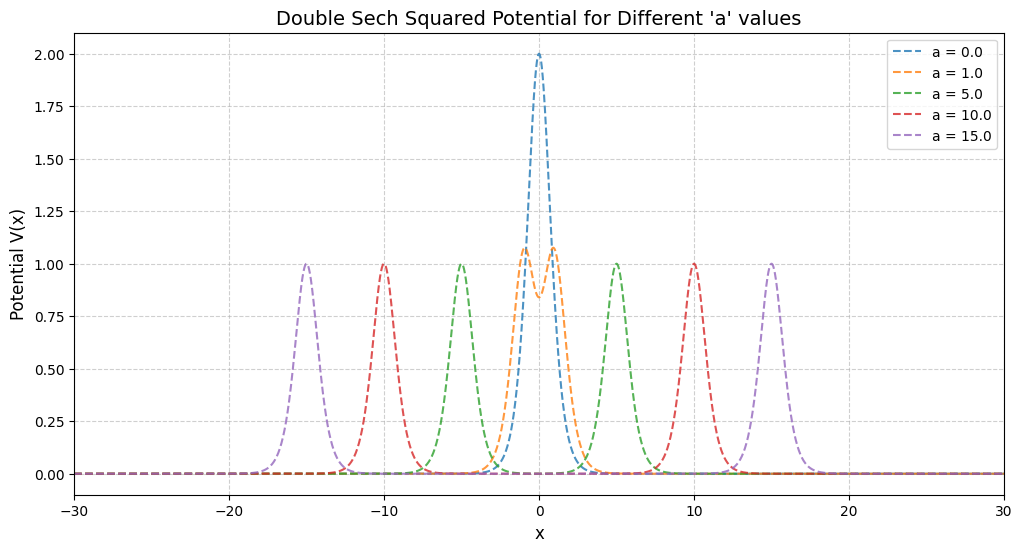

In [4]:
import numpy as np
from scipy.optimize import brentq
from scipy.integrate import simpson
import matplotlib.pyplot as plt

def potential(x, b, a, c):
    """
    Potential function V(x) = b(sech^2((x - a) / c) + sech^2((x + a) / c))
    For positive b, this represents a potential barrier.
    """
    return b / np.cosh((x - a) / c)**2 + b / np.cosh((x + a) / c)**2

def numerov_step(psi_prev, psi_curr, k_prev_sq, k_curr_sq, k_next_sq, dx):
    """
    Applies the Numerov method to find the next point of the wave function.
    Based on the formula:
    psi(x+dx) * (1 + dx^2/12 * k(x+dx)^2) = 2*psi(x) * (1 - 5*dx^2/12 * k(x)^2) - psi(x-dx) * (1 + dx^2/12 * k(x-dx)^2)
    where k(x)^2 = 2m/hbar^2 * (E - V(x)).
    We use units where 2m/hbar^2 = 1 for simplicity, so k^2 = E - V(x).
    """
    denom = 1 + dx**2 / 12 * k_next_sq
    if abs(denom) < 1e-10:
        return np.nan

    psi_next = (2 * psi_curr * (1 - 5 * dx**2 / 12 * k_curr_sq) -
                  psi_prev * (1 + dx**2 / 12 * k_prev_sq)) / denom
    return psi_next


def solve_schrodinger_single_sweep(energy, x, dx, potential_func, params):
    """
    Solves the time-independent Schrödinger equation for a given energy
    using the Numerov method by integrating from the left boundary to the right.
    Assumes hard wall boundary condition psi(x_min) = 0.
    Returns the unnormalized wave function. Uses units where 2m/hbar^2 = 1.
    """
    n_points = len(x)
    psi = np.zeros(n_points)
    psi[0] = 0.0
    psi[1] = 1e-5 * dx

    # Update params tuple to use the current 'a' value passed in params
    current_b, current_a, current_c = params
    k2 = energy - potential_func(x, current_b, current_a, current_c)

    for i in range(1, n_points - 1):
        k_prev_sq = k2[i-1]
        k_curr_sq = k2[i]
        k_next_sq = k2[i+1] if i + 1 < n_points else k2[i]

        psi[i+1] = numerov_step(psi[i-1], psi[i], k_prev_sq, k_curr_sq, k_next_sq, dx)

        if np.isnan(psi[i+1]):
             return np.full(n_points, np.nan)

    return psi


def shoot_mismatch(energy, x, dx, potential_func, params):
    """
    Calculates the mismatch for the shooting method.
    """
    psi = solve_schrodinger_single_sweep(energy, x, dx, potential_func, params)
    if np.isnan(psi).any():
        return np.inf
    return psi[-1]


# --- Parameters ---
b = 1.0
# We will iterate over 'a'
c = 1.0

# Spatial grid
x_min = -30.0
x_max = 30.0
n_points = 3001
x, dx = np.linspace(x_min, x_max, n_points, retstep=True)

# List of 'a' values to test
a_values = [0.0, 1.0, 5.0, 10.0, 15.0]

# Store results
eigenvalues_by_a = {}

# --- Loop through 'a' values and find eigenvalues ---
for current_a in a_values:
    print(f"Calculating eigenvalues for a = {current_a}")

    # Potential on the grid for the current 'a'
    v_x = potential(x, b, current_a, c)

    # Adjust search range based on the potential height (b)
    energy_min_search = 0.0
    energy_max_search = b * 5 # Max energy to search for

    num_test_energies = 1000
    energies_test = np.linspace(energy_min_search, energy_max_search, num_test_energies)

    # Calculate the mismatch for each test energy
    # Pass the current 'a' value in the params tuple
    mismatch_values = [shoot_mismatch(E, x, dx, potential, (b, current_a, c)) for E in energies_test]

    valid_indices = ~np.isnan(mismatch_values)
    valid_energies_test = energies_test[valid_indices]
    valid_mismatch_values = np.array(mismatch_values)[valid_indices]

    sign_changes = np.where(np.sign(valid_mismatch_values[:-1]) != np.sign(valid_mismatch_values[1:]))[0]

    eigenvalues = []

    # Use brentq to find the accurate eigenvalue
    for i in sign_changes:
        try:
            # Pass the current 'a' value in the params tuple
            eigenvalue = brentq(shoot_mismatch, valid_energies_test[i], valid_energies_test[i+1],
                                             args=(x, dx, potential, (b, current_a, c)))
            eigenvalues.append(eigenvalue)
        except ValueError:
            pass

    eigenvalues.sort()
    print(f"Found {len(eigenvalues)} eigenvalues for a = {current_a}")
    eigenvalues_by_a[current_a] = eigenvalues

# --- Plotting Dispersion Plot ---
plt.figure(figsize=(12, 8))

for current_a, eigenvalues in eigenvalues_by_a.items():
    # State numbers are 0-indexed
    state_numbers = np.arange(len(eigenvalues))
    plt.scatter(state_numbers, eigenvalues, label=f'a = {current_a}', s=50) # s is marker size

plt.xlabel("State Number", fontsize=12)
plt.ylabel("Eigenenergy (arbitrary units)", fontsize=12)
plt.title("Eigenenergy Dispersion for Different Barrier Separations (a)", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(bottom=0) # Ensure energy starts from 0
plt.show()

# Optional: Plot the potential for different 'a' values to see how it changes
plt.figure(figsize=(12, 6))
for current_a in a_values:
    v_x = potential(x, b, current_a, c)
    plt.plot(x, v_x, label=f'a = {current_a}', linestyle='--', alpha=0.8)

plt.xlabel("x", fontsize=12)
plt.ylabel("Potential V(x)", fontsize=12)
plt.title("Double Sech Squared Potential for Different 'a' values", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(x_min, x_max)
plt.show()

Dirac energies: [-0.0903494  -0.0903494  -0.03802501 -0.03802501  0.0142995   0.0142995
  0.06662407  0.06662407]


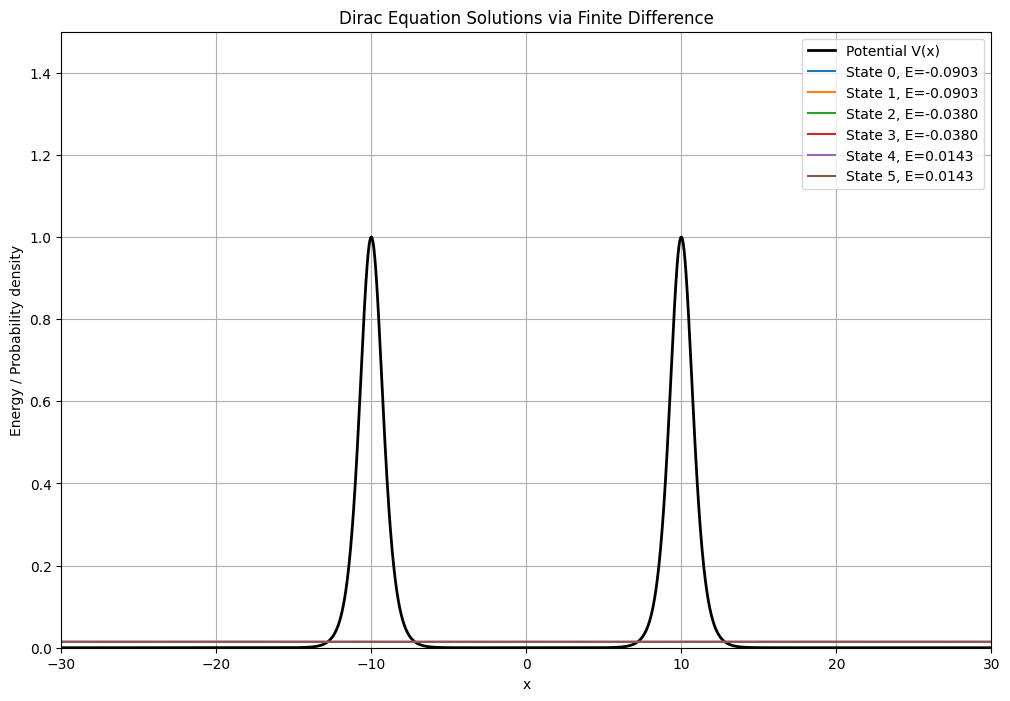

In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

# --- Dirac Equation via Finite Difference Method in 1D ---
# We consider the low-energy (massless) Dirac Hamiltonian for graphene electrons in 1D:
# H = -i v_F sigma_x d/dx + V(x) I_2, with v_F = 1 (units), sigma_x Pauli matrix.
# Discretize on a grid with central differences. The spinor has two components at each site.

# Pauli matrices
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_0 = np.eye(2, dtype=complex)

# Potential function as before
def potential(x, b, a, c):
    return b / np.cosh((x - a) / c)**2 + b / np.cosh((x + a) / c)**2

# Build Dirac Hamiltonian matrix (2N x 2N)
def build_dirac_hamiltonian(x, V_x, vF=1.0):
    N = len(x)
    dx = x[1] - x[0]
    # Kinetic term: -i vF sigma_x d/dx
    # Use central difference: d/dx psi_i ~ (psi_{i+1} - psi_{i-1})/(2 dx)
    # So kinetic coupling between i and i+1: -(i vF/(2 dx)) sigma_x
    off_diag = -1j * vF / (2 * dx)
    # Construct sparse blocks
    data = []
    rows = []
    cols = []
    # Loop over grid points
    for i in range(N):
        # On-site potential term: V(x_i) * I_2
        for s in [0, 1]:
            idx = 2*i + s
            data.append(V_x[i])
            rows.append(idx)
            cols.append(idx)
        # Kinetic couplings
        if i < N-1:
            # coupling i -> i+1 and i+1 -> i
            for s1 in [0, 1]:
                for s2 in [0, 1]:
                    # matrix element for spin block
                    kin = off_diag * sigma_x[s1, s2]
                    # i to i+1
                    rows.append(2*i + s1)
                    cols.append(2*(i+1) + s2)
                    data.append(kin)
                    # i+1 to i (hermitian conjugate)
                    rows.append(2*(i+1) + s2)
                    cols.append(2*i + s1)
                    data.append(np.conjugate(kin))
    H = sp.coo_matrix((data, (rows, cols)), shape=(2*N, 2*N), dtype=complex)
    return H.tocsr()

# Solver function
def solve_dirac_fd(x, b, a, c, num_states=6, vF=1.0):
    # Compute potential
    V_x = potential(x, b, a, c)
    # Build Hamiltonian
    H = build_dirac_hamiltonian(x, V_x, vF=vF)
    # Solve for lowest magnitude eigenvalues around zero
    # Use shift-invert around zero
    eigvals, eigvecs = spla.eigsh(H, k=num_states, sigma=0.0, which='LM')
    # Sort eigenvalues and eigenvectors
    idx = np.argsort(eigvals)
    eigvals = eigvals[idx].real
    eigvecs = eigvecs[:, idx]
    # Reshape spinors
    spinors = [eigvecs[:, i].reshape(2, -1) for i in range(num_states)]
    return eigvals, spinors

# --- Parameters and grid ---
b = 1.0
a = 10.0
c = 1.0
x_min, x_max, N = -30.0, 30.0, 3001
x = np.linspace(x_min, x_max, N)

# Solve Dirac
energies_dirac, spinor_wfs = solve_dirac_fd(x, b, a, c, num_states=8)
print("Dirac energies:", energies_dirac)

# Plot spinor probability densities |psi|^2 for first few states
plt.figure(figsize=(12, 8))
Vx = potential(x, b, a, c)
plt.plot(x, Vx, color='black', linewidth=2, label='Potential V(x)')
for i, psi in enumerate(spinor_wfs[:6]):
    # probability density = |psi1|^2 + |psi2|^2
    prob = np.abs(psi[0])**2 + np.abs(psi[1])**2
    plt.plot(x, prob * 0.5 + energies_dirac[i], label=f"State {i}, E={energies_dirac[i]:.4f}")

plt.xlabel('x')
plt.ylabel('Energy / Probability density')
plt.title('Dirac Equation Solutions via Finite Difference')
plt.legend()
plt.grid(True)
plt.xlim(x_min, x_max)
plt.ylim(min(Vx)*1.1, max(Vx)*1.5)
plt.show()


Found energies: [-0.09040963 -0.09040963 -0.03805036 -0.03805036  0.01430904  0.01430904
  0.06666848  0.06666848]


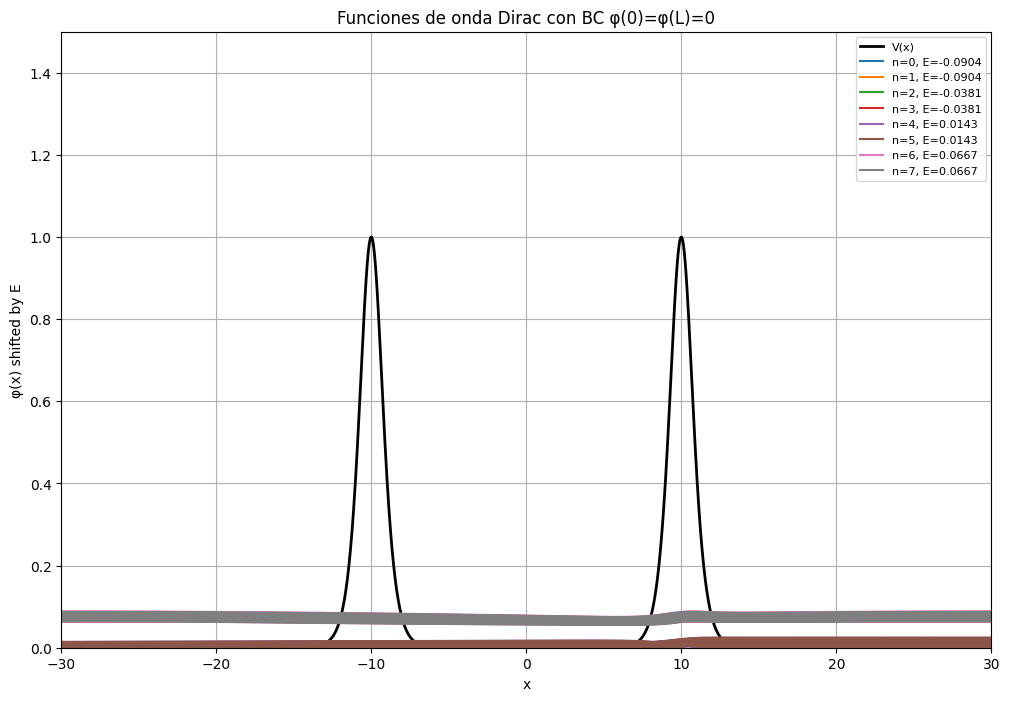

In [6]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

# --- Dirac Equation via Finite Difference with Hard-Wall BC in 1D ---
# We impose φ(0)=φ(L)=0 by excluding boundary points from the grid.

sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)

# Potential
def potential(x, b, a, c):
    return b / np.cosh((x - a) / c)**2 + b / np.cosh((x + a) / c)**2

# Build Hamiltonian on interior points only
def build_dirac_hamiltonian_interior(x_int, V_int, vF=1.0):
    N = len(x_int)
    dx = x_int[1] - x_int[0]
    off = -1j * vF / (2*dx)
    data, rows, cols = [], [], []
    for i in range(N):
        # on-site potential
        for s in (0,1):
            idx = 2*i + s
            data.append(V_int[i])
            rows.append(idx); cols.append(idx)
        # kinetic couplings
        if i < N-1:
            for s1 in (0,1):
                for s2 in (0,1):
                    kin = off * sigma_x[s1,s2]
                    # i->i+1
                    rows.append(2*i+s1); cols.append(2*(i+1)+s2); data.append(kin)
                    # hermitian
                    rows.append(2*(i+1)+s2); cols.append(2*i+s1); data.append(np.conjugate(kin))
    H = sp.coo_matrix((data,(rows,cols)), shape=(2*N,2*N), dtype=complex)
    return H.tocsr()

# Solve Dirac on interior grid
def solve_dirac_hardwall(x, b, a, c, num_states=8, vF=1.0):
    # full grid and interior
    x_full = x
    x_int = x_full[1:-1]
    V_int = potential(x_int, b, a, c)
    H = build_dirac_hamiltonian_interior(x_int, V_int, vF=vF)
    eigvals, eigvecs = spla.eigsh(H, k=num_states, sigma=0.0, which='LM')
    idx = np.argsort(eigvals)
    eigvals = eigvals[idx].real
    eigvecs = eigvecs[:, idx]
    # reconstruct φ with zeros at boundaries
    spinors = []
    for j in range(num_states):
        psi_int = eigvecs[:,j].reshape(2, len(x_int))
        # prepend and append zeros for φ component
        phi = np.zeros(len(x_full), dtype=complex)
        phi[1:-1] = psi_int[0]
        spinors.append(phi)
    return eigvals, spinors

# --- Parameters and grid ---
b, a, c = 1.0, 10.0, 1.0
x = np.linspace(-30, 30, 3001)

# Solve
energies, phis = solve_dirac_hardwall(x, b, a, c, num_states=8)
print("Found energies:", energies)

# Plot φ(x)
plt.figure(figsize=(12,8))
Vx = potential(x, b, a, c)
plt.plot(x, Vx, color='black', linewidth=2, label='V(x)')
scale = (max(Vx)-min(Vx))*1
for i, (E, phi) in enumerate(zip(energies, phis)):
    plt.plot(x, phi.real*scale + E, label=f"n={i}, E={E:.4f}")

plt.xlabel('x')
plt.ylabel('φ(x) shifted by E')
plt.title('Funciones de onda Dirac con BC φ(0)=φ(L)=0')
plt.legend(fontsize=8)
plt.grid(True)
plt.xlim(x[0], x[-1])
plt.ylim(min(Vx)*1.1, max(Vx)*1.5)
plt.show()



Primeros 20 niveles ligados (E): [np.float64(-1.0321035682869322), np.float64(-0.9274773582918288), np.float64(-0.8228467932167064), np.float64(-0.7705300207645754), np.float64(-0.6658937825215703), np.float64(-0.5612543351589174), np.float64(-0.508933551310503), np.float64(-0.35196764672861697), np.float64(-0.29964468520172577), np.float64(-0.24732132251605135), np.float64(-0.19499761597690918), np.float64(-0.09034940056125237), np.float64(-0.038025006296984715), np.float64(0.014299502596392184), np.float64(0.1712731439853189), np.float64(0.38056946071401804), np.float64(0.43289282360674186), np.float64(0.4852157853725512), np.float64(0.7991419232684487), np.float64(0.9037781624676196)]


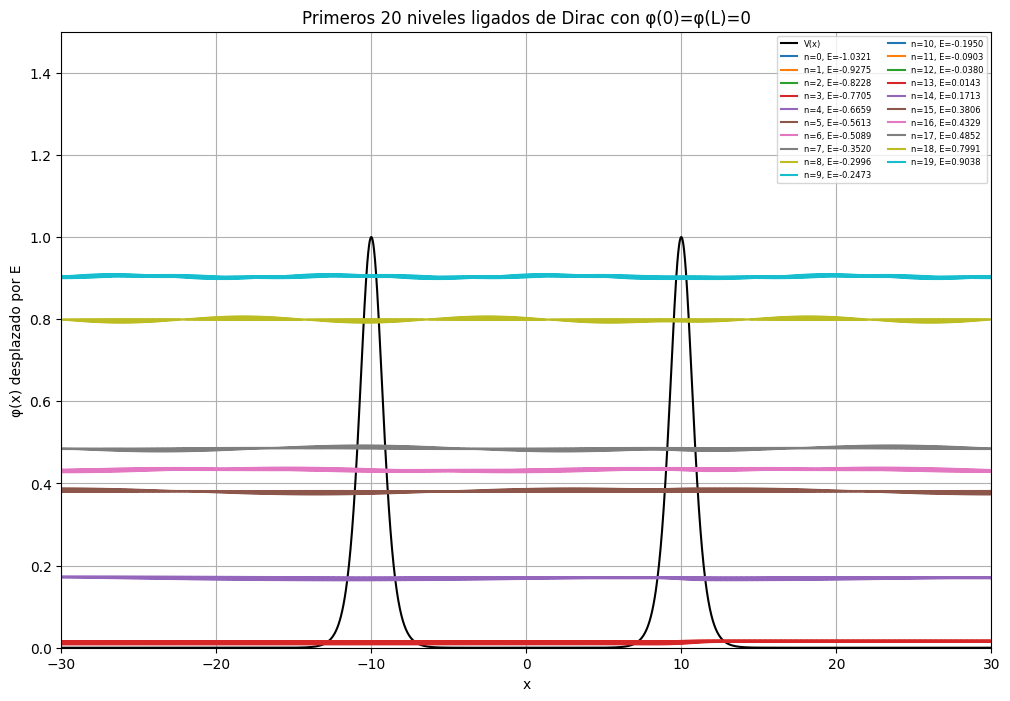

In [8]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

# --- Dirac Equation via Finite Difference Method in 1D ---
# Low-energy Dirac Hamiltonian for graphene electrons in 1D with hard-wall Dirichlet BC: φ(0)=φ(L)=0

sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)

def potential(x, b, a, c):
    return b / np.cosh((x - a) / c)**2 + b / np.cosh((x + a) / c)**2

def build_dirac_hamiltonian(x, V_x, vF=1.0):
    N = len(x)
    dx = x[1] - x[0]
    off = -1j * vF / (2 * dx)
    data, rows, cols = [], [], []
    for i in range(N):
        # on-site potential
        for s in (0,1):
            idx = 2*i + s
            data.append(V_x[i]); rows.append(idx); cols.append(idx)
        # kinetic coupling
        if i < N-1:
            for s1 in (0,1):
                for s2 in (0,1):
                    kin = off * sigma_x[s1,s2]
                    # i -> i+1
                    rows.append(2*i+s1); cols.append(2*(i+1)+s2); data.append(kin)
                    # hermitian conj
                    rows.append(2*(i+1)+s2); cols.append(2*i+s1); data.append(np.conjugate(kin))
    H = sp.coo_matrix((data,(rows,cols)), shape=(2*N,2*N), dtype=complex)
    return H.tocsr()

# Solve Dirac and return first N bound states with φ(0)=φ(L)=0

def solve_dirac_firstN(x, b, a, c, Nlevels=20, vF=1.0, num_states=4*20, tol=1e-2):
    V_x = potential(x, b, a, c)
    H = build_dirac_hamiltonian(x, V_x, vF)
    # compute a few more eigenvalues in shift-invert around zero
    eigvals, eigvecs = spla.eigsh(H, k=num_states, sigma=0.0, which='LM')
    idx = np.argsort(eigvals)
    eigvals = eigvals[idx].real; eigvecs = eigvecs[:,idx]
    bound_E, bound_spinors = [], []
    N = len(x)
    for j, E in enumerate(eigvals):
        if len(bound_E) >= Nlevels:
            break
        spinor = eigvecs[:,j].reshape(2, N)
        phi = spinor[0]
        if abs(phi[0])<tol and abs(phi[-1])<tol:
            bound_E.append(E)
            bound_spinors.append(spinor)
    return bound_E, bound_spinors, V_x

# --- Parameters and grid ---
b, a, c = 1.0, 10.0, 1.0
x = np.linspace(-30,30,3001)

# Compute first 20 bound states
energies, spinors, Vx = solve_dirac_firstN(x, b, a, c, Nlevels=20)
print("Primeros 20 niveles ligados (E):", energies)

# Plot φ(x) for each of the 20 states
plt.figure(figsize=(12,8))
plt.plot(x, Vx, 'k', linewidth=1.5, label='V(x)')
scale = (max(Vx)-min(Vx))*0.3
for i, (E, spinor) in enumerate(zip(energies, spinors)):
    phi = spinor[0].real
    plt.plot(x, phi*scale + E, label=f"n={i}, E={E:.4f}")

plt.xlabel('x')
plt.ylabel('φ(x) desplazado por E')
plt.title('Primeros 20 niveles ligados de Dirac con φ(0)=φ(L)=0')
plt.legend(fontsize=6, ncol=2)
plt.grid(True)
plt.xlim(x[0], x[-1])
plt.ylim(min(Vx)*1.1, max(Vx)*1.5)
plt.show()
